In [44]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from hyperopt import hp, fmin, tpe, Trials
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Read parquet file as dataframe
df = pd.read_parquet('bert_transformed.parquet')
df = df.drop(columns=["headline", "short_description", "authors"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209080 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   category                     209080 non-null  object
 1   headline_embedding           209080 non-null  object
 2   short_description_embedding  209080 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


In [54]:
# Faltten embeddings to prepare for modeling

summary_cols = [f"headline_embedding_{i}" for i in range(768)] 

# Convert the embeddings to Dataframe
embedding_df = pd.DataFrame(df['headline_embedding'].tolist(), index=df.index, columns=summary_cols)

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, embedding_df], axis=1)

# Drop the original embedding columns
df = df.drop(columns=['headline_embedding'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209080 entries, 0 to 209526
Columns: 770 entries, category to headline_embedding_767
dtypes: float32(768), object(2)
memory usage: 617.3+ MB


In [55]:
# Initialize test and training dataset split
X = df.drop(columns=['category', 'short_description_embedding'])  # Drop the target column (labels)
y = df['category']  # The target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [56]:
k = 5

results = {
    'Model': [],
    'Accuracy': [],
    'Accuracy SD': [],
    'Precision': [],
    'Precision SD': [],
    'Recall': [],
    'Recall SD': [],
    'F1-Score': [],
    'F1-Score SD': [],
}

In [57]:
# Set space and optimization function for Gaussian Bayes hyperparameter tuning

space = {
    'var_smoothing': hp.loguniform('var_smoothing', -11, -3)  # log-uniform distribution
}

def objective(params):
    # Extract hyperparameters
    var_smoothing = params['var_smoothing']

    # Initialize the Gaussian Naive Bayes model with the current hyperparameter
    model = GaussianNB(var_smoothing=var_smoothing)

    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy (minimize the error, so we return 1 - accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    return 1 - accuracy  # Hyperopt minimizes the objective, so we return 1 - accuracy

trials = Trials()

# Perform the optimization using the TPE algorithm
optimal = fmin(fn=objective,  # Objective function to minimize
            space=space,    # Hyperparameter search space
            algo=tpe.suggest,  # Optimization algorithm (TPE)
            max_evals=50,  # Number of evaluations
            trials=trials)  # Store the results

  2%|▏          | 1/50 [00:05<04:40,  5.72s/trial, best loss: 0.713435048785154]


KeyboardInterrupt: 

Average Accuracy across 5-folds: 0.2845


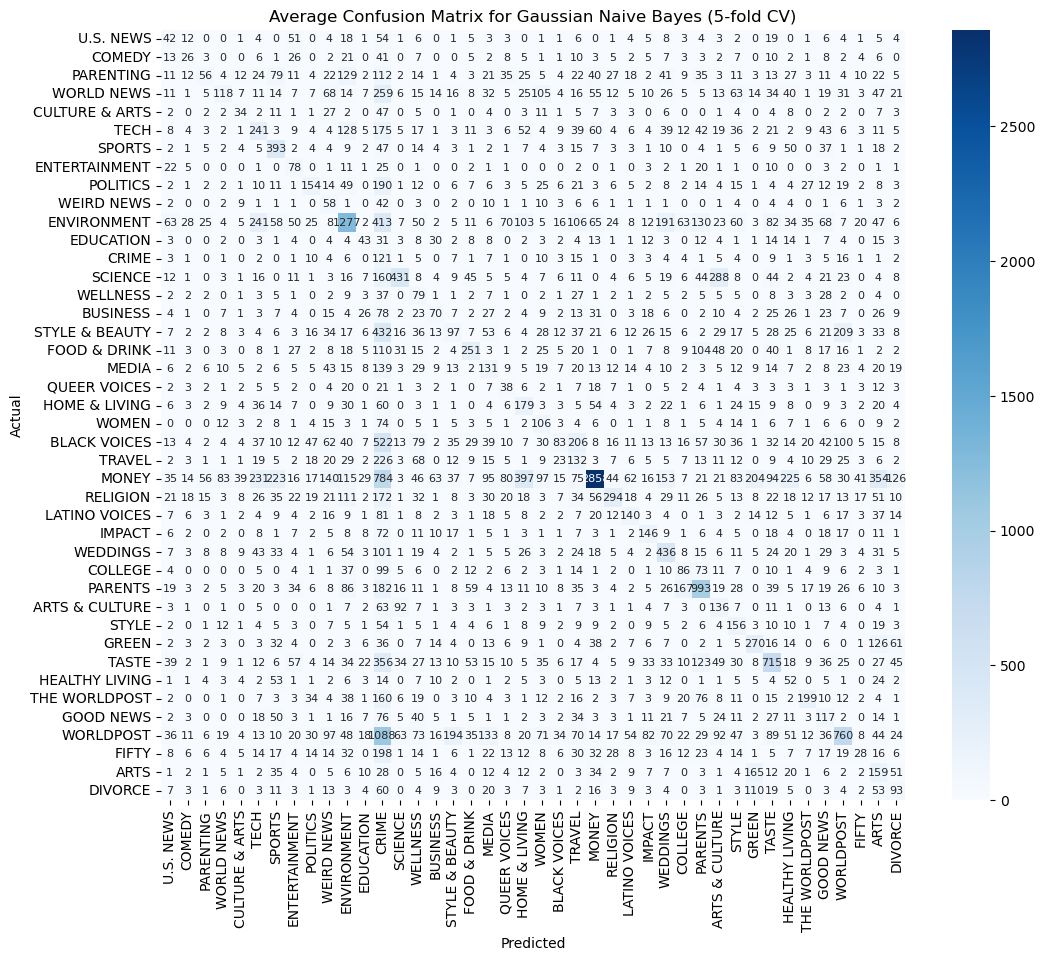

In [58]:
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=32)
GNB = GaussianNB()

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the Logistic Regression model with L1 regularization (Lasso)
    GNB.fit(X_train, y_train)

    # Make predictions
    y_pred = GNB.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = accuracy_score(y_test, y_pred) 
    precision = precision_score(y_test, y_pred, average='weighted') # weighted to reflect class imbalance
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
results['Model'].append("Gaussian Naive Bayes")
results['Accuracy'].append(np.mean(accuracies))
results['Accuracy SD'].append(np.std(accuracies))
results['Precision'].append(np.mean(precisions))
results['Precision SD'].append(np.std(precisions))
results['Recall'].append(np.mean(recalls))
results['Recall SD'].append(np.std(recalls))
results['F1-Score'].append(np.mean(f1s))
results['F1-Score SD'].append(np.std(f1s))
# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plt.figure(figsize=(12, 10))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['category'].unique(), yticklabels=df['category'].unique(), annot_kws={"size": 8})
plt.title(f"Average Confusion Matrix for Gaussian Naive Bayes ({k}-fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
results

{'Model': ['Gaussian Naive Bayes'],
 'Accuracy': [0.27010713602448827],
 'Accuracy SD': [0.003433259442227077],
 'Precision': [0.27010713602448827],
 'Precision SD': [0.003433259442227077],
 'Recall': [0.27010713602448827],
 'Recall SD': [0.003433259442227077],
 'F1-Score': [0.27010713602448827],
 'F1-Score SD': [0.003433259442227077]}